In [ ]:
df = pd.read_parquet("large_dataframe.parquet")
df

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Load your data
df = pd.read_parquet("large_dataframe.parquet")

# Convert pickup_dateTime to datetime and set as index
df['pickup_dateTime'] = pd.to_datetime(df['pickup_dateTime'])
df.set_index('pickup_dateTime', inplace=True)

# Select the time series to analyze (e.g., trip_distance)
y = df['trip_distance']

# Resample the data to daily frequency (or any other frequency you prefer)
y_resampled = y.resample('D').sum()  # Summing distances for each day

# Check for stationarity and perform differencing if necessary
# For simplicity, we will assume the data is already stationary or has been differenced

# Fit the ARIMA model
model = ARIMA(y_resampled, order=(1, 1, 1))  # Adjust the order as needed
model_fit = model.fit()

# Make predictions
# Here we predict the next 10 days; adjust as necessary
y_pred = model_fit.forecast(steps=10)

# Calculate RMSE
# Assuming you have the last 10 actual values for comparison
actual_values = y_resampled[-10:]  # Adjust this based on your data
rmse = np.sqrt(mean_squared_error(actual_values, y_pred))
print(f'RMSE: {rmse}')

In [39]:
import pandas as pd

# Convert pickup_dateTime to datetime
df['pickup_dateTime'] = pd.to_datetime(df['pickup_dateTime'])

# Group by the hour of pickup_dateTime
df_grouped = df.groupby(df['pickup_dateTime'].dt.floor('h')).agg({
    # Aggregation methods for different columns
    'trip_distance': 'mean',  # average trip distance per hour
    'tolls_amount': 'sum',    # total tolls per hour
    'total_amount': 'sum',    # total amount per hour
    'trip_duration (mins)': 'mean',  # average trip duration per hour
    'speed (miles/hr)': 'mean',  # average speed per hour
    'fare per mile': 'mean',
    'is_holiday': 'first',    # assume holiday status is consistent for the hour
    'pickup_temperature (°C)': 'mean',
    'pickup_precipitation (mm)': 'mean',
    'pickup_rain (mm)': 'mean',
    'dropoff_temperature (°C)': 'mean',
    'dropoff_precipitation (mm)': 'mean',
    'dropoff_rain (mm)': 'mean'
})

# Reset index to make the datetime a column
df_grouped = df_grouped.reset_index()

# Rename the datetime column if you want
df_grouped = df_grouped.rename(columns={'pickup_dateTime': 'hour'})

# Print the grouped DataFrame
print(df_grouped)

# Optional: Save to CSV if you want
# df_grouped.to_csv('hourly_grouped_data.csv', index=False)
# df_grouped.to_csv('grouped_data.csv', index=False)

                    hour  trip_distance  tolls_amount  total_amount  \
0    2023-01-01 00:00:00       3.367844        458.85      58736.84   
1    2023-01-01 01:00:00       3.326414       1144.86     154747.46   
2    2023-01-01 02:00:00       3.273783        956.85     136303.83   
3    2023-01-01 03:00:00       3.557245        900.75     116854.20   
4    2023-01-01 04:00:00       3.672817        848.45      84476.51   
...                  ...            ...           ...           ...   
8755 2023-12-31 19:00:00       3.519082       2102.87     117234.42   
8756 2023-12-31 20:00:00       3.439614       1966.73     131237.64   
8757 2023-12-31 21:00:00       3.508005       2095.76     134750.61   
8758 2023-12-31 22:00:00       3.477034       1275.89     119643.92   
8759 2023-12-31 23:00:00       3.004668        874.29      76908.92   

      trip_duration (mins)  speed (miles/hr)  fare per mile  is_holiday  \
0                18.513993         12.968865      12.141659           1 

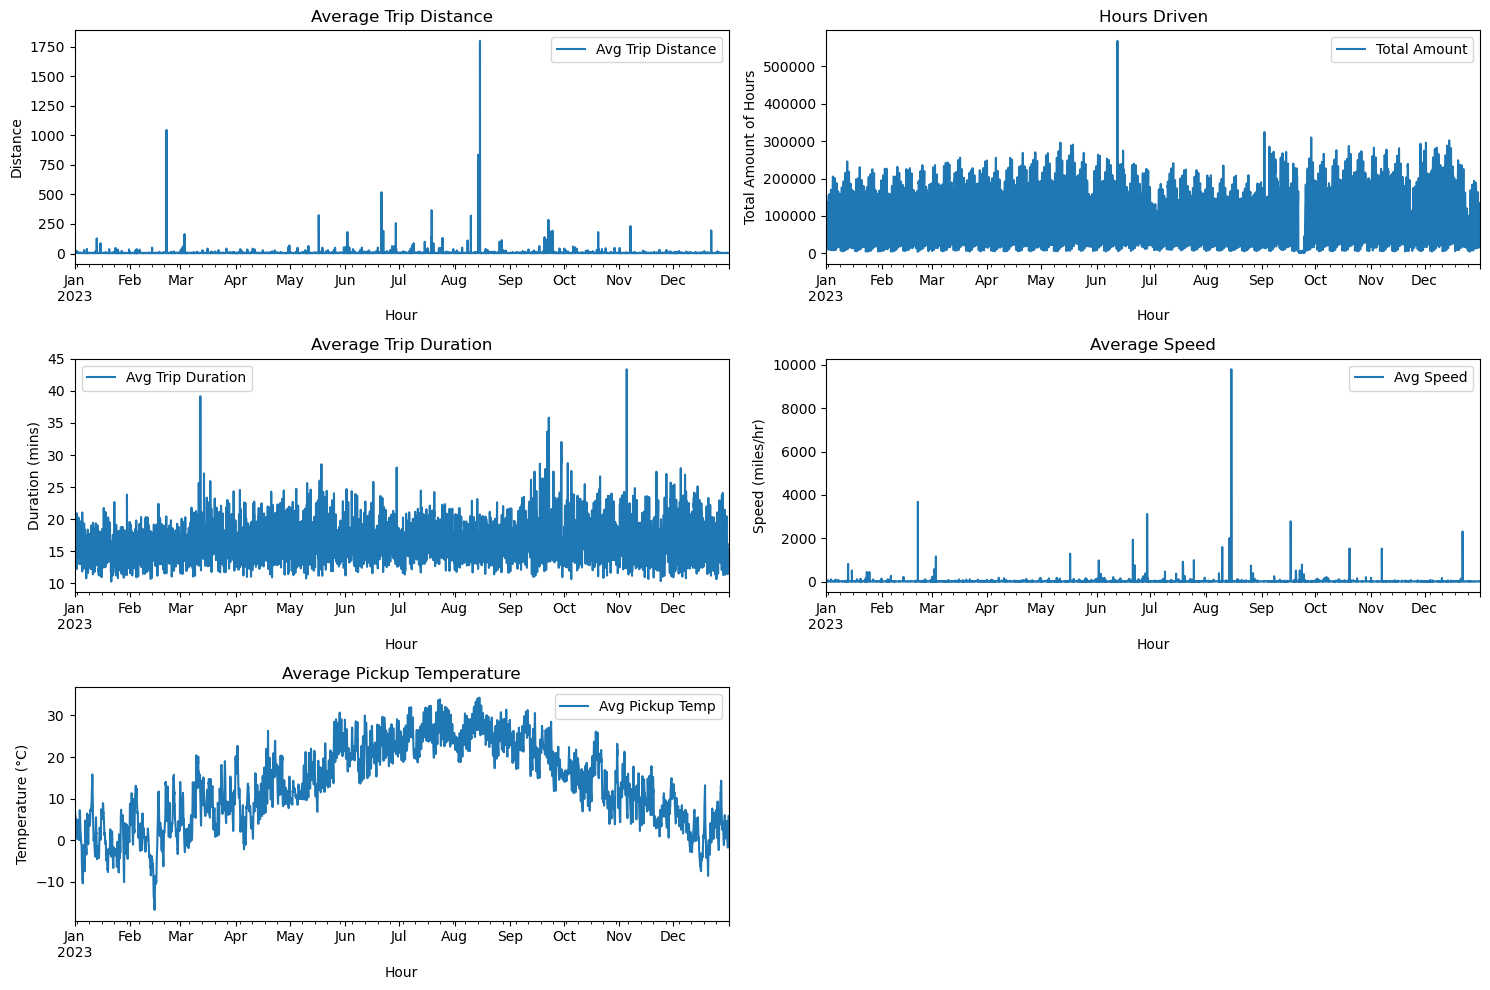

In [60]:
import matplotlib.pyplot as plt

# Use the grouped DataFrame we created earlier
plt.figure(figsize=(15,10))

# You can choose different columns to plot
# Example plots - adjust based on what you want to visualize
plt.subplot(3,2,1)
df_grouped.plot(x='hour', y='trip_distance', ax=plt.gca(), label='Avg Trip Distance')
plt.title('Average Trip Distance')
plt.xlabel('Hour')
plt.ylabel('Distance')

plt.subplot(3,2,2)
df_grouped.plot(x='hour', y='total_amount', ax=plt.gca(), label='Total Amount')
plt.title('Hours Driven')
plt.xlabel('Hour')
plt.ylabel('Total Amount of Hours')

plt.subplot(3,2,3)
df_grouped.plot(x='hour', y='trip_duration (mins)', ax=plt.gca(), label='Avg Trip Duration')
plt.title('Average Trip Duration')
plt.xlabel('Hour')
plt.ylabel('Duration (mins)')

plt.subplot(3,2,4)
df_grouped.plot(x='hour', y='speed (miles/hr)', ax=plt.gca(), label='Avg Speed')
plt.title('Average Speed')
plt.xlabel('Hour')
plt.ylabel('Speed (miles/hr)')

plt.subplot(3,2,5)
df_grouped.plot(x='hour', y='pickup_temperature (°C)', ax=plt.gca(), label='Avg Pickup Temp')
plt.title('Average Pickup Temperature')
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def predict_demand(df_grouped):
    """
    Predict demand using available features
    """
    # Extract time-based features
    df_grouped['hour_of_day'] = pd.to_datetime(df['hour']).dt.hour
    df_grouped['day_of_week'] = pd.to_datetime(df['hour']).dt.dayofweek
    df_grouped['month'] = pd.to_datetime(df['hour']).dt.month

    # Select features for prediction
    features = [
        'hour_of_day', 'day_of_week', 'month',
        'trip_distance', 'tolls_amount'
    ]
    
    target = 'total_amount'
    
    # Prepare X and y
    X = df[features]
    y = df[target]
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest model
    model = RandomForestRegressor(
        n_estimators=100, 
        random_state=42, 
        max_depth=10
    )
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print("Model Performance:")
    print(f"Mean Squared Error: {mse:,.2f}")
    print(f"R-squared Score: {r2:.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Visualization of actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Total Amount')
    plt.ylabel('Predicted Total Amount')
    plt.title('Actual vs Predicted Total Amount')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'mse': mse,
        'r2': r2,
        'feature_importance': feature_importance
    }

# Run the prediction
# result = predict_demand(df_grouped)

Parameters (1, 1, 1, 1, 1, 1): RMSE = 112213.63531075961
Parameters (0, 1, 1, 1, 1, 1): RMSE = 112237.85901680798
Parameters (1, 1, 0, 1, 1, 0): RMSE = 1251898.1045122042
Parameters (2, 1, 2, 1, 1, 1): RMSE = 111551.532893324
Parameters (0, 1, 0, 1, 1, 0): RMSE = 1258186.9640486564

Best Parameters:
Non-Seasonal and Seasonal Order: (2, 1, 2, 1, 1, 1)
Best RMSE: 111551.532893324


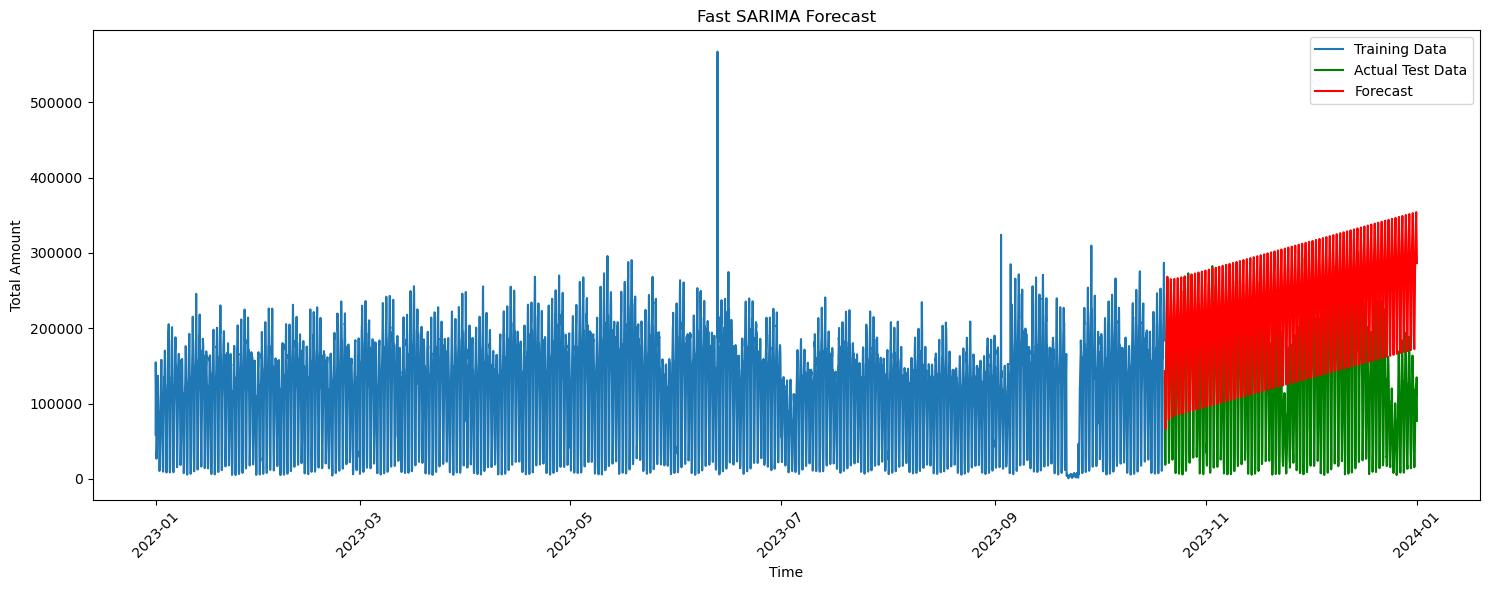

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

def quick_sarima_optimization(train, test, max_iterations=10):
    """
    Quickly find good SARIMA parameters with reduced computational complexity
    """
    warnings.filterwarnings('ignore')
    
    # Predefined parameter combinations to test
    param_combinations = [
        # (p,d,q,P,D,Q)
        (1,1,1,1,1,1),   # Baseline
        (0,1,1,1,1,1),   # Reduced AR terms
        (1,1,0,1,1,0),   # Reduced MA terms
        (2,1,2,1,1,1),   # Slightly more complex
        (0,1,0,1,1,0)    # Minimal complexity
    ]
    
    best_rmse = float('inf')
    best_params = None
    best_forecast = None
    
    for params in param_combinations[:max_iterations]:
        try:
            # Unpack parameters
            p, d, q, P, D, Q = params
            
            # Fit SARIMA model
            model = SARIMAX(train, 
                            order=(p,d,q), 
                            seasonal_order=(P,D,Q,24))
            model_fit = model.fit(disp=False)
            
            # Forecast
            forecast = model_fit.get_forecast(steps=len(test))
            forecast_mean = forecast.predicted_mean
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test, forecast_mean))
            
            # Update best model
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params
                best_forecast = forecast_mean
            
            print(f"Parameters {params}: RMSE = {rmse}")
            
        except Exception as e:
            print(f"Failed with parameters {params}: {e}")
            continue
    
    return best_params, best_rmse, best_forecast

def fast_sarima_forecast(df, target_column='total_amount', test_size=0.2):
    """
    Perform fast SARIMA forecasting with limited parameter optimization
    """
    # Prepare time series data
    df_ts = df.set_index('hour')
    df_ts = df_ts.sort_index()
    time_series = df_ts[target_column]
    
    # Split data
    split_index = int(len(time_series) * (1 - test_size))
    train = time_series[:split_index]
    test = time_series[split_index:]
    
    # Find best parameters quickly
    best_params, best_rmse, best_forecast = quick_sarima_optimization(train, test)
    
    print("\nBest Parameters:")
    print(f"Non-Seasonal and Seasonal Order: {best_params}")
    print(f"Best RMSE: {best_rmse}")
    
    # Plot results
    plt.figure(figsize=(15,6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data', color='green')
    plt.plot(test.index, best_forecast, label='Forecast', color='red')
    plt.title('Fast SARIMA Forecast')
    plt.xlabel('Time')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return best_params, best_rmse, best_forecast

# Execute the fast forecasting
best_params, optimized_rmse, forecast = fast_sarima_forecast(df_grouped)

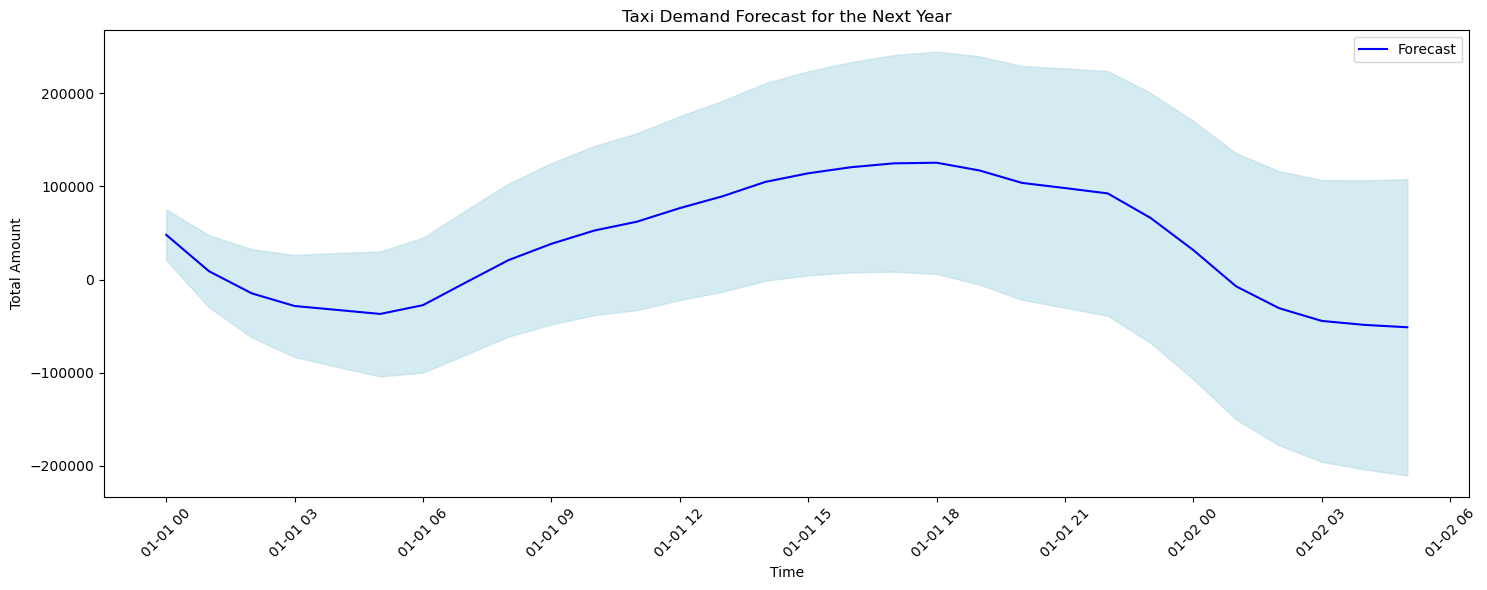

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare the data
def prepare_sarima_data(df, target_column='total_amount'):
    # Ensure the datetime column is in the correct format
    df['hour'] = pd.to_datetime(df['hour'])
    
    # Set hour as the index
    df_ts = df.set_index('hour')
    
    # Aggregate the target column by hour (sum or mean, depending on use case)
    time_series = df_ts[target_column].resample('H').sum()
    
    return time_series

# Fit SARIMA model
def fit_sarima_model(time_series, order=(1,1,1), seasonal_order=(1,1,1,24)):
    """
    Fit SARIMA model with specified orders
    
    Parameters:
    - time_series: Complete time series data
    - order: (p,d,q) for non-seasonal part
    - seasonal_order: (P,D,Q,m) for seasonal part
    """
    model = SARIMAX(time_series, 
                    order=order, 
                    seasonal_order=seasonal_order)
    
    model_fit = model.fit(disp=False)
    return model_fit

# Forecast for the next year
def forecast_next_year(model_fit, periods=30):
    forecast = model_fit.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    plt.figure(figsize=(15,6))
    plt.plot(forecast_mean, label='Forecast', color='blue')
    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='lightblue', alpha=0.5)
    plt.title('Taxi Demand Forecast for the Next Year')
    plt.xlabel('Time')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main execution
def main(df):
    # Prepare data
    time_series = prepare_sarima_data(df)
    
    # Fit SARIMA model
    model_fit = fit_sarima_model(time_series, 
                                 order=(1,1,1),           # Non-seasonal order (p,d,q)
                                 seasonal_order=(1,1,1,24)) # Seasonal order (P,D,Q,m)
    
    # Forecast for the next year
    forecast_next_year(model_fit)
    
    return model_fit

# Assuming the dataset is loaded into a DataFrame called df
  # Replace with your dataset's filename
model_fit = main(df_grouped)